# WildFires predictions w/ PyTorch

## Importing the libraries

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os

import torch
import torchvision
import torchvision.transforms as transforms

## Import data

To import data, we will create a data loader for the test dataset, the train and the validation ones.

In [4]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

Creating dataframes for validation, test and training

In [5]:
from torchvision.io import read_image

def checkfile(filepath):
    try:
        img = read_image(filepath)
        return True
    except:
        print(f"{filepath} Image could not be read")
        return False

In [6]:
filenames, annots = [], []
for filename in os.listdir(os.path.join('/kaggle/input/wildfire-prediction-dataset/test', 'nowildfire')):
    if checkfile(os.path.join('/kaggle/input/wildfire-prediction-dataset/test', 'nowildfire', filename)):
        filenames.append(os.path.join('nowildfire', filename))
        annots.append(0)
for filename in os.listdir(os.path.join('/kaggle/input/wildfire-prediction-dataset/test', 'wildfire')):
    if checkfile(os.path.join('/kaggle/input/wildfire-prediction-dataset/test', 'wildfire', filename)):
        filenames.append(os.path.join('wildfire', filename))
        annots.append(1)
df_test = pd.DataFrame(columns=['filename', 'wildfire'])
df_test['filename'] = filenames
df_test['wildfire'] = annots

df_test.shape

/kaggle/input/wildfire-prediction-dataset/test/wildfire/-73.15884,46.38819.jpg Image could not be read


(6299, 2)

In [16]:
df_test.sample(3)

,filename,wildfire
1342,"nowildfire/-122.888217,49.119473.jpg",0
524,"nowildfire/-122.888174,49.241536.jpg",0
348,"nowildfire/-73.607027,45.559924.jpg",0


In [17]:
filenames, annots = [], []
for filename in os.listdir(os.path.join('/kaggle/input/wildfire-prediction-dataset/train', 'nowildfire')):
    if checkfile(os.path.join('/kaggle/input/wildfire-prediction-dataset/train', 'nowildfire', filename)):
        filenames.append(os.path.join('nowildfire', filename))
        annots.append(0)
for filename in os.listdir(os.path.join('/kaggle/input/wildfire-prediction-dataset/train', 'wildfire')):
    if checkfile(os.path.join('/kaggle/input/wildfire-prediction-dataset/train', 'wildfire', filename)):
        filenames.append(os.path.join('wildfire', filename))
        annots.append(1)
df_train = pd.DataFrame(columns=['filename', 'wildfire'])
df_train['filename'] = filenames
df_train['wildfire'] = annots

df_train.shape

/kaggle/input/wildfire-prediction-dataset/train/nowildfire/-114.152378,51.027198.jpg Image could not be read


(30249, 2)

In [18]:
filenames, annots = [], []
for filename in os.listdir(os.path.join('/kaggle/input/wildfire-prediction-dataset/valid', 'nowildfire')):
    if checkfile(os.path.join('/kaggle/input/wildfire-prediction-dataset/valid', 'nowildfire', filename)):
        filenames.append(os.path.join('nowildfire', filename))
        annots.append(0)
for filename in os.listdir(os.path.join('/kaggle/input/wildfire-prediction-dataset/valid', 'wildfire')):
    if checkfile(os.path.join('/kaggle/input/wildfire-prediction-dataset/valid', 'wildfire', filename)):
        filenames.append(os.path.join('wildfire', filename))
        annots.append(1)
df_val = pd.DataFrame(columns=['filename', 'wildfire'])
df_val['filename'] = filenames
df_val['wildfire'] = annots

df_val.shape

(6300, 2)

### PLOT all fires using locations on a map

Creating a custom dataset class

In [19]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
#         self.img_labels = pd.read_csv(annotations_file)
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = image.float()
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [20]:
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((350, 350))
])

test_data = CustomImageDataset(df_test, '/kaggle/input/wildfire-prediction-dataset/test', transform=transform)
training_data = CustomImageDataset(df_train, '/kaggle/input/wildfire-prediction-dataset/train', transform=transform)
val_data = CustomImageDataset(df_val, '/kaggle/input/wildfire-prediction-dataset/valid', transform=transform)

In [21]:
test_data[500]

(tensor([[[159., 157., 131.,  ...,  89.,  43.,  25.],
          [159., 155., 139.,  ..., 119.,  61.,  81.],
          [159., 157., 165.,  ..., 189., 117., 113.],
          ...,
          [159., 167., 161.,  ..., 245., 325., 365.],
          [143., 157., 163.,  ..., 185., 251., 323.],
          [135., 147., 159.,  ..., 141., 181., 259.]],
 
         [[203., 197., 163.,  ..., 109.,  69.,  59.],
          [199., 195., 171.,  ..., 139.,  87., 115.],
          [193., 191., 195.,  ..., 209., 143., 147.],
          ...,
          [181., 189., 183.,  ..., 245., 323., 363.],
          [165., 179., 183.,  ..., 185., 255., 327.],
          [157., 169., 179.,  ..., 141., 185., 263.]],
 
         [[127., 123.,  91.,  ...,  41.,   9.,  -1.],
          [125., 121.,  99.,  ...,  71.,  27.,  51.],
          [125., 123., 129.,  ..., 141.,  83.,  83.],
          ...,
          [113., 121., 115.,  ..., 197., 281., 321.],
          [ 97., 111., 115.,  ..., 137., 211., 283.],
          [ 89., 101., 111.,  .

### Prepare the data for training with DataLoaders

In [22]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

> Iterate through the DataLoader

Feature batch shape: torch.Size([64, 3, 350, 350])
Labels batch shape: torch.Size([64])


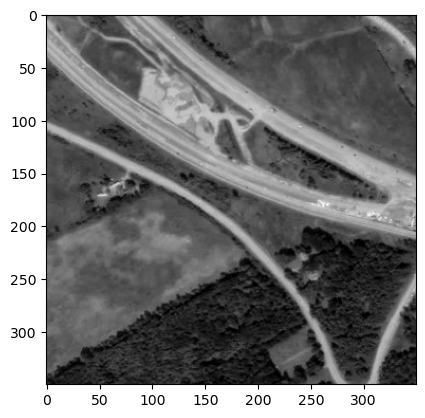

Label: 0


In [23]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [24]:
classes = ('no wildfire', 'wildfire')

## Define a Convolutional Neural Network

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 87 * 87, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 87 * 87)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 3, 1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(3, 3, 1)
#         self.fc1 = nn.Linear(22707, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 2)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

### Define a Loss function and optimizer

In [26]:
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

In [29]:
import torch.optim as optim

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, train_dataloader, criterion, optimizer, epochs=2)

[1,   100] loss: 8.323
[1,   200] loss: 0.698
[1,   300] loss: 0.695
[1,   400] loss: 0.693
[2,   100] loss: 0.692
[2,   200] loss: 0.693
[2,   300] loss: 0.693
[2,   400] loss: 0.693


KeyboardInterrupt: 

### Train the network

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [31]:
PATH = './net-2.pth'
torch.save(model.state_dict(), PATH)

## Test the network on the test data

In [69]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

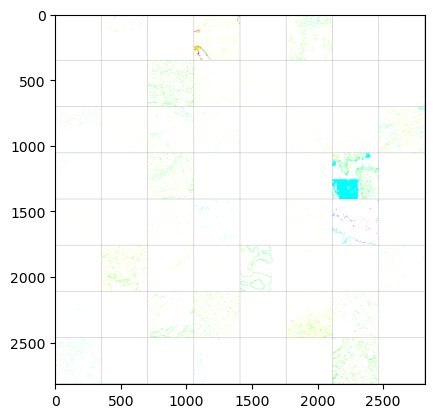

GroundTruth:  wildfire wildfire wildfire wildfire


In [70]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [71]:
outputs = net(images)
outputs

tensor([[-0.5751, -1.0212],
        [ 1.0169, -2.4662],
        [-2.5239,  0.7177],
        [-1.6671, -0.1857],
        [ 1.0530, -2.0456],
        [-0.6964, -0.6151],
        [-1.6431, -0.3109],
        [ 2.1941, -3.4178],
        [-2.0339,  0.2811],
        [-2.4505,  0.6176],
        [ 1.1404, -2.2498],
        [-1.6690,  0.0502],
        [-2.4702,  0.7245],
        [-1.0389, -0.3253],
        [-2.3830,  0.6480],
        [-1.7579,  0.1378],
        [-1.7460, -0.0436],
        [ 0.7899, -2.1501],
        [-2.1144,  0.3611],
        [-2.4661,  0.7171],
        [-2.4803,  0.6699],
        [-2.5870,  0.6688],
        [-2.4980,  0.7110],
        [-2.3366,  0.6587],
        [-2.3775,  0.6276],
        [-2.2036,  0.5240],
        [ 1.0339, -1.9772],
        [ 3.1749, -5.0625],
        [-1.3530, -0.0504],
        [ 2.8438, -3.9246],
        [-2.1347,  0.5966],
        [ 1.4124, -2.7546],
        [-2.4141,  0.6487],
        [ 4.1343, -6.0945],
        [ 1.1439, -2.0731],
        [-1.6578,  0

In [72]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  no wildfire no wildfire wildfire wildfire


Let us look at how the network performs on the whole dataset.

In [33]:
correct = 0
total = 0

# We're not training, we do not need to calculate the gradients
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the test images: {100 * correct // total} %")

Accuracy of the network on the test images: 55 %


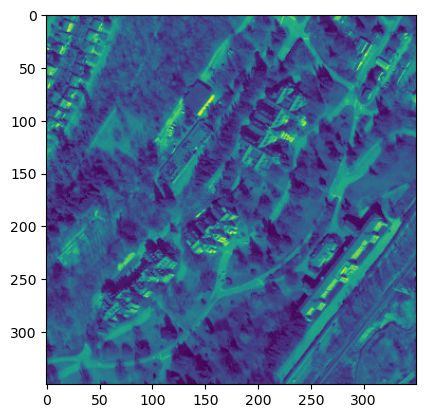

In [48]:
image = test_data[0][0]
plt.imshow(image[0])
plt.show()

In [50]:
with torch.no_grad():
    model.eval()
    image_path = './backend/sample_image.jpg'
    # image = read_image(image_path)
    # image = image.float()
#     image = images[0]
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)
    print(predicted)

tensor([1])
